In [49]:
import neuralfoil as nf  # `pip install neuralfoil`
import numpy as np
import matplotlib.pyplot as plt  # `pip install matplotlib`
import matplotlib.cm as cm  # Colormap module
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from aerosandbox.geometry.airfoil.airfoil_families import get_kulfan_parameters
import aerosandbox as asb
from scipy.interpolate import griddata

In [36]:
# Set parameters
Re = 1e5
alphas_nf = np.arange(-16, 22, 1) # np.linspace(-60, 60, 600)
airfoil = asb.Airfoil("naca0014")
models = ["xxsmall", "xsmall", "small", "medium", "large", "xlarge", "xxlarge", "xxxlarge"]

# Choose a group of airfoils
thickness_airfoils = ["naca0009", "naca0012", "naca0015", "naca0018", "naca0021", "naca0024", "naca0027", "naca0030"]
camber_airfoils = ["naca0012", "naca2412", "naca4412"]

In [3]:
# Global colormap data
cmap = cm.viridis #winter #inferno
norm = plt.Normalize(0, len(models) - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

In [4]:
# Get Kulfan parameters example
kulfan_params = get_kulfan_parameters(
    airfoil.coordinates,
    n_weights_per_side=8
)

print(kulfan_params)

lower_weights = kulfan_params["lower_weights"] #[] # sample array
upper_weights = kulfan_params["upper_weights"] #[] # sample array
leading_edge_weight = kulfan_params["leading_edge_weight"] # sample value
TE_thickness = kulfan_params["TE_thickness"] # sample value

print("Lower weights: ", lower_weights)

# Create kulfan_params
kulfan_params = {
    "lower_weights": lower_weights,
    "upper_weights": upper_weights,
    "leading_edge_weight": leading_edge_weight,
    "TE_thickness": TE_thickness
}


{'lower_weights': array([-0.20169847, -0.1768234 , -0.20272357, -0.14896092, -0.19228821,
       -0.14743867, -0.17021421, -0.16239955]), 'upper_weights': array([0.20169847, 0.1768234 , 0.20272357, 0.14896092, 0.19228821,
       0.14743867, 0.17021421, 0.16239955]), 'TE_thickness': 0.0029725496888779734, 'leading_edge_weight': -3.804419138626366e-16}
Lower weights:  [-0.20169847 -0.1768234  -0.20272357 -0.14896092 -0.19228821 -0.14743867
 -0.17021421 -0.16239955]


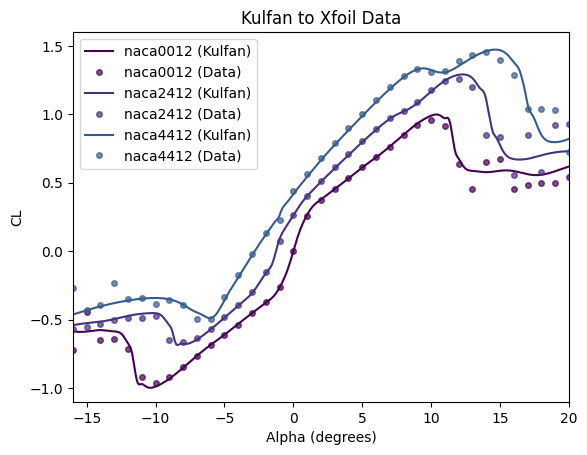

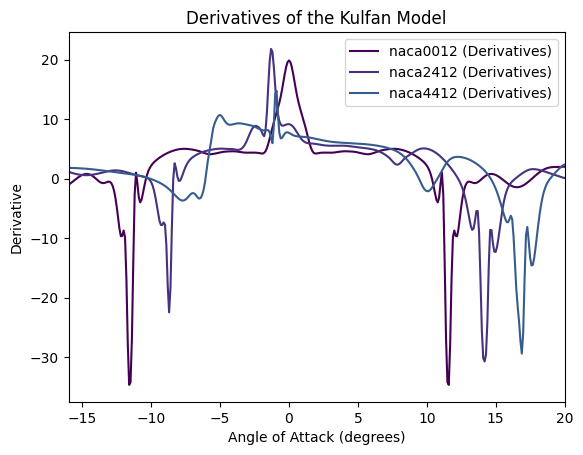

In [27]:
## Use airfoil names to get Kulfan parameters for various cambered airfoils

# Create a figure and an axis
fig, ax = plt.subplots()

# Dictionary to store derivatives for each airfoil
kulfan_derivatives = {}

# Function to compute numerical derivatives
def numerical_derivative(alpha, cl):
    return np.gradient(cl, alpha)

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(camber_airfoils):
    airfoil = asb.Airfoil(airfoil_name)

    # Get kulfan parameters
    kulfan_params = get_kulfan_parameters(
    airfoil.coordinates,
    n_weights_per_side=8
    )

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )
    ax.plot(alphas_nf, aero["CL"], color=cmap(norm(idx)), label=f"{airfoil_name} (Kulfan)")

    # Add data from results_airfoilname.dat to the plot
    results_file = "results_" + airfoil_name + ".dat"
    results_data = np.loadtxt(results_file, skiprows=1)  # Skip header row
    alpha_data = results_data[:, 0]  # First column for alpha
    cl_data = results_data[:, 1]  # Second column for CL
    ax.plot(alpha_data, cl_data, linestyle="", marker='o', markersize=4, color=cmap(norm(idx)), label=f"{airfoil_name} (Data)", alpha = 0.7)

    # Compute the numerical derivatives of the Kulfan model at the given alpha values
    derivatives = numerical_derivative(alphas_nf, aero["CL"])
    kulfan_derivatives[airfoil_name] = derivatives

# Add labels, title, and colorbar
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CL")
ax.set_xlim(-16, 20)
ax.set_ylim(-1.1, 1.6)
ax.grid(False)
ax.set_title("Kulfan to Xfoil Data")
ax.legend()

# Plot the derivatives
fig, ax3 = plt.subplots()

for idx, (label, derivatives) in enumerate(kulfan_derivatives.items()):
    ax3.plot(alphas_nf, derivatives*180/np.pi, label=f'{label} (Derivatives)', color=cmap(norm(idx)))

# Add labels, title, and legend to the derivatives plot
ax3.set_xlabel('Angle of Attack (degrees)')
ax3.set_ylabel('Derivative')
ax3.set_title('Derivatives of the Kulfan Model')
ax3.set_xlim(-16, 20)
# ax3.set_ylim(-1, 1)
ax3.legend()

plt.show()

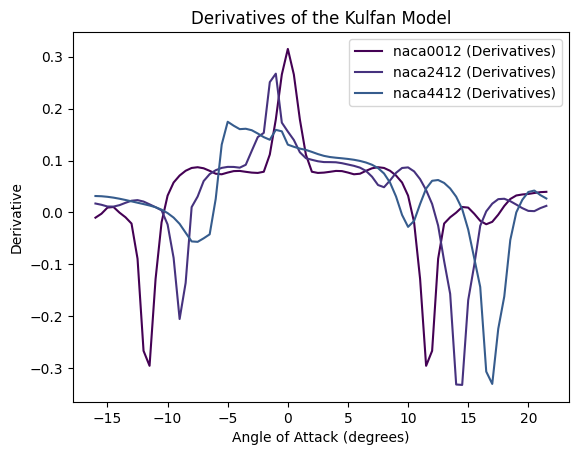

In [10]:
# Plot the derivatives
fig, ax3 = plt.subplots()

for idx, (label, derivatives) in enumerate(kulfan_derivatives.items()):
    ax3.plot(alphas_nf, derivatives, label=f'{label} (Derivatives)', color=cmap(norm(idx)))

# Add labels, title, and legend to the derivatives plot
ax3.set_xlabel('Angle of Attack (degrees)')
ax3.set_ylabel('Derivative')
ax3.set_title('Derivatives of the Kulfan Model')
ax3.legend()

plt.show()

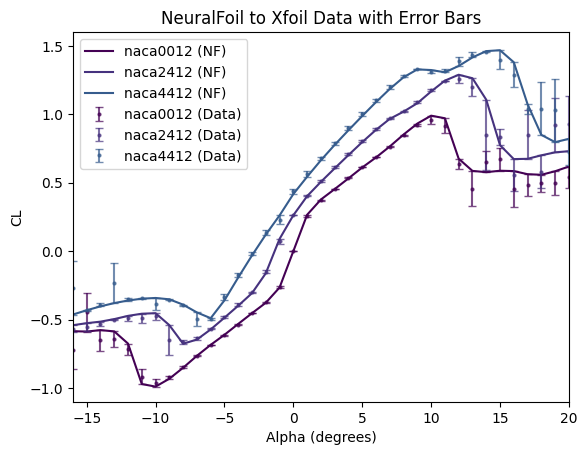

In [21]:
## ALTERNATIVE WITH ERROR BARS ##
# Create a figure and an axis for the alternative plot with error bars
fig, ax = plt.subplots()

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(camber_airfoils):
    airfoil = asb.Airfoil(airfoil_name)

    # Get kulfan parameters
    kulfan_params = get_kulfan_parameters(
        airfoil.coordinates,
        n_weights_per_side=8
    )

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )
    ax.plot(alphas_nf, aero["CL"], color=cmap(norm(idx)), label=f"{airfoil_name} (NF)")

    # Add data from results_airfoilname.dat to the plot
    results_file = "results_" + airfoil_name + ".dat"
    results_data = np.loadtxt(results_file, skiprows=1)  # Skip header row
    alpha_data = results_data[:, 0]  # First column for alpha
    cl_data = results_data[:, 1]  # Second column for CL

    # Interpolate the Kulfan model predictions to match the alpha_data points
    interpolated_cl = np.interp(alpha_data, alphas_nf, aero["CL"])

    # Calculate the error between the data points and the Kulfan model predictions
    error = np.abs(cl_data - interpolated_cl)  # Absolute error

    # Plot the data points with error bars
    ax.errorbar(
        alpha_data,  # x-values (data points)
        cl_data,  # y-values (data points)
        yerr=error,  # Error bars (absolute error)
        fmt='o',  # Circular markers
        markersize=2,
        color=cmap(norm(idx)), 
        label=f"{airfoil_name} (Data)", 
        capsize=3,  # Add caps to the error bars
        alpha=0.7   # Transparency for better visualization
    )

    # Compute the numerical derivatives of the Kulfan model at the given alpha values
    derivatives = numerical_derivative(alphas_nf, aero["CL"])
    kulfan_derivatives[airfoil_name] = derivatives

# Add labels, title, and colorbar
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CL")
ax.set_xlim(-16, 20)
ax.set_ylim(-1.1, 1.6)
ax.grid(False)
ax.set_title("NeuralFoil to Xfoil Data with Error Bars")
ax.legend()

In [22]:
## Calculate MAE ##
# Initialize a list to store MAE for each airfoil
mae_list = []

# Loop through each airfoil
for idx, airfoil_name in enumerate(camber_airfoils):
    airfoil = asb.Airfoil(airfoil_name)

    # Get Kulfan parameters and model predictions
    kulfan_params = get_kulfan_parameters(
        airfoil.coordinates,
        n_weights_per_side=8
    )
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )

    # Load data points
    results_file = "results_" + airfoil_name + ".dat"
    results_data = np.loadtxt(results_file, skiprows=1)  # Skip header row
    alpha_data = results_data[:, 0]  # First column for alpha
    cl_data = results_data[:, 1]  # Second column for CL

    # Interpolate the Kulfan model predictions to match the alpha_data points
    interpolated_cl = np.interp(alpha_data, alphas_nf, aero["CL"])

    # Calculate the absolute errors
    absolute_errors = np.abs(cl_data - interpolated_cl)

    # Compute Mean Absolute Error (MAE)
    mae = np.mean(absolute_errors)

    # Store the MAE
    mae_list.append(mae)

    # Print the MAE for the current airfoil
    print(f"Airfoil: {airfoil_name}")
    print(f"  Mean Absolute Error (MAE): {mae:.6f}")

# Optionally, compute the overall MAE across all airfoils
overall_mae = np.mean(mae_list)

print("\nOverall Mean Absolute Error (MAE):")
print(f"  {overall_mae:.6f}")

Airfoil: naca0012
  Mean Absolute Error (MAE): 0.045204
Airfoil: naca2412
  Mean Absolute Error (MAE): 0.048959
Airfoil: naca4412
  Mean Absolute Error (MAE): 0.048327

Overall Mean Absolute Error (MAE):
  0.047497


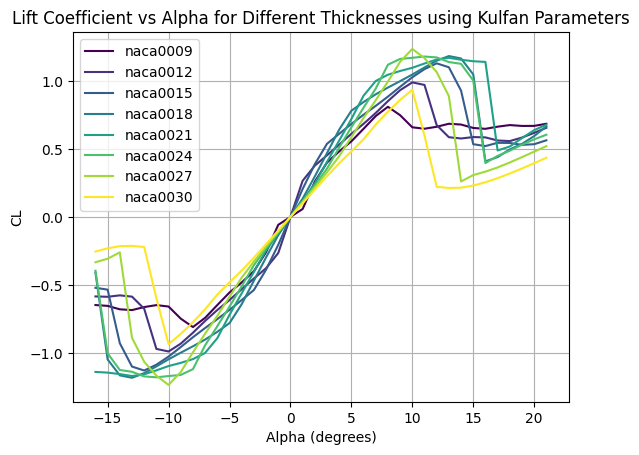

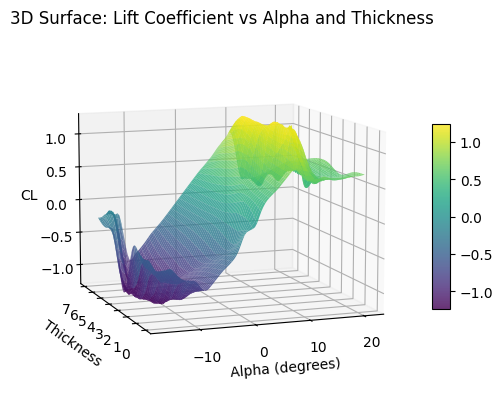

In [56]:
## Use airfoil names to get Kulfan parameters for various thicknesses of airfoils

# Create a 2D figure and axis for the original 2D plot
fig, ax = plt.subplots()

# Create a 3D figure and axis for the 3D surface plot
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Define a colormap
cmap = plt.cm.viridis
norm = plt.Normalize(0, len(thickness_airfoils) - 1)

# Initialize lists to store data for the 3D surface plot
alpha_values = []
thickness_values = []
cl_values = []

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(thickness_airfoils):
    airfoil = asb.Airfoil(airfoil_name)

    # Get Kulfan parameters
    kulfan_params = get_kulfan_parameters(
        airfoil.coordinates,
        n_weights_per_side=8
    )

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )

    # Assume thickness is encoded in the airfoil name or can be extracted from Kulfan parameters
    thickness = kulfan_params.get("thickness", idx)  # Replace with actual thickness if available

    # Plot the 2D curve (alpha vs CL)
    ax.plot(alphas_nf, aero["CL"], label=airfoil_name, color=cmap(norm(idx)))

    # Store data for the 3D surface plot
    alpha_values.extend(alphas_nf)
    thickness_values.extend([thickness] * len(alphas_nf))
    cl_values.extend(aero["CL"])

# Add labels, title, and legend to the 2D plot
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CL")
ax.set_title("Lift Coefficient vs Alpha for Different Thicknesses using Kulfan Parameters")
ax.legend()
ax.grid(True)

# Interpolate the data for the 3D surface plot
alpha_grid, thickness_grid = np.meshgrid(
    np.linspace(min(alpha_values), max(alpha_values), 100),
    np.linspace(min(thickness_values), max(thickness_values), 100)
)
cl_grid = griddata(
    (alpha_values, thickness_values), cl_values,
    (alpha_grid, thickness_grid), method='cubic'
)

# Plot the 3D surface
surf = ax_3d.plot_surface(
    alpha_grid, thickness_grid, cl_grid,
    cmap=cmap, edgecolor='none', alpha=0.8
)

# Add labels, title, and colorbar to the 3D plot
ax_3d.set_xlabel("Alpha (degrees)")
ax_3d.set_ylabel("Thickness")
ax_3d.set_zlabel("CL")
ax_3d.set_title("3D Surface: Lift Coefficient vs Alpha and Thickness")
fig_3d.colorbar(surf, ax=ax_3d, shrink=0.5, aspect=10)

ax_3d.view_init(elev=10, azim=250)  # Adjust the view angle for better visualization

# Show both plots
plt.show()

In [31]:
### Try creating a kulfan parameters bank

# Define the Kulfan Parameters class
class KulfanParameters:
    def __init__(self):
        self.lower_weights = None
        self.upper_weights = None
        self.leading_edge_weight = None
        self.TE_thickness = None

    def set_parameters(self, lower_weights, upper_weights, leading_edge_weight, TE_thickness):
        self.lower_weights = lower_weights
        self.upper_weights = upper_weights
        self.leading_edge_weight = leading_edge_weight
        self.TE_thickness = TE_thickness

    def to_dict(self):
        return {
            "lower_weights": self.lower_weights,
            "upper_weights": self.upper_weights,
            "leading_edge_weight": self.leading_edge_weight,
            "TE_thickness": self.TE_thickness,
        }

# Define the Kulfan Parameters Bank class
class KulfanParametersBank:
    def __init__(self):
        self.bank = {}

    def add_airfoil(self, name, lower_weights, upper_weights, leading_edge_weight, TE_thickness):
        kf = KulfanParameters()
        kf.set_parameters(lower_weights, upper_weights, leading_edge_weight, TE_thickness)
        self.bank[name] = kf.to_dict()

    def get_airfoil(self, name):
        return self.bank.get(name, None)

    def list_airfoils(self):
        return list(self.bank.keys())

    def display_bank(self):
        for name, params in self.bank.items():
            print(f'Name: "{name}"')
            for key, value in params.items():
                print(f'  {key}: {value}')
            print()

    # Create a function to take in an airfoil name and return the Kulfan parameters
    def add_airfoil_by_name(self, airfoil_name):
            airfoil = asb.Airfoil(airfoil_name)
            params = get_kulfan_parameters(airfoil.coordinates, n_weights_per_side=8)
            self.add_airfoil(airfoil_name, **params)


In [44]:
# Example usage
kulfan_bank = KulfanParametersBank()

# # Add airfoils to the bank
# kulfan_bank.add_airfoil(
#     name="NACA0012",
#     lower_weights=[0.1, 0.2, 0.3],
#     upper_weights=[0.1, 0.2, 0.3],
#     leading_edge_weight=0.01,
#     TE_thickness=0.02
# )

# kulfan_bank.add_airfoil(
#     name="NACA2412",
#     lower_weights=[0.15, 0.25, 0.35],
#     upper_weights=[0.15, 0.25, 0.35],
#     leading_edge_weight=0.02,
#     TE_thickness=0.03
# )

# kulfan_bank.add_airfoil_by_name("naca0012")
for airfoil_name in thickness_airfoils:
    kulfan_bank.add_airfoil_by_name(airfoil_name)

# Add in the custom airfoil
# kulfan_bank.add_airfoil(
#     name="naca0013.5",
#     lower_weights=[-0.19449495, -0.17050829, -0.19548344, -0.14364089, -0.18542077, -0.14217300, -0.16413513, -0.15659957], 
#     upper_weights=[0.19449495, 0.17050829, 0.19548344, 0.14364089, 0.18542077, 0.14217300, 0.16413513, 0.15659957], 
#     leading_edge_weight=-3.4273922475165367e-16, 
#     TE_thickness=0.0028663872000144446, 
# )

# Retrieve an airfoil's parameters
# naca0012_params = kulfan_bank.get_airfoil("naca0012")
# print("naca0012 Parameters:", naca0012_params)

# List all airfoils in the bank
airfoil_list = kulfan_bank.list_airfoils()
print("Airfoils in the bank:", airfoil_list)

# Display the entire bank
kulfan_bank.display_bank()

Airfoils in the bank: ['naca0009', 'naca0012', 'naca0015', 'naca0018', 'naca0021', 'naca0024', 'naca0027', 'naca0030']
Name: "naca0009"
  lower_weights: [-0.1296633  -0.11367219 -0.13032229 -0.09576059 -0.12361385 -0.094782
 -0.10942342 -0.10439971]
  upper_weights: [0.1296633  0.11367219 0.13032229 0.09576059 0.12361385 0.094782
 0.10942342 0.10439971]
  leading_edge_weight: -1.7992055917375184e-16
  TE_thickness: 0.001910924799992983

Name: "naca0012"
  lower_weights: [-0.1728844  -0.15156292 -0.17376306 -0.12768079 -0.16481846 -0.126376
 -0.14589789 -0.13919961]
  upper_weights: [0.1728844  0.15156292 0.17376306 0.12768079 0.16481846 0.126376
 0.14589789 0.13919961]
  leading_edge_weight: -4.087778939030135e-16
  TE_thickness: 0.0025478997333239634

Name: "naca0015"
  lower_weights: [-0.2161055  -0.18945365 -0.21720382 -0.15960099 -0.20602308 -0.15797
 -0.18237237 -0.17399952]
  upper_weights: [0.2161055  0.18945365 0.21720382 0.15960099 0.20602308 0.15797
 0.18237237 0.17399952]
  

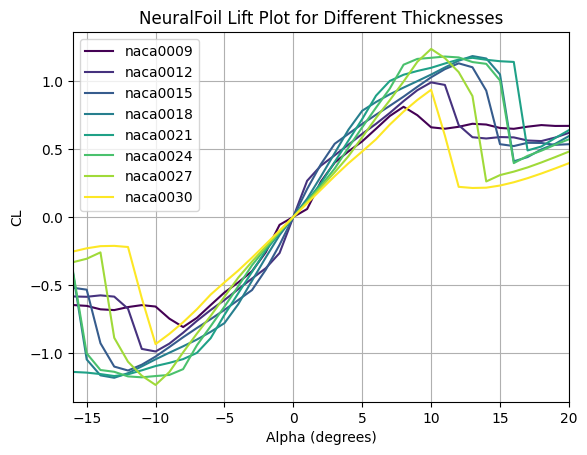

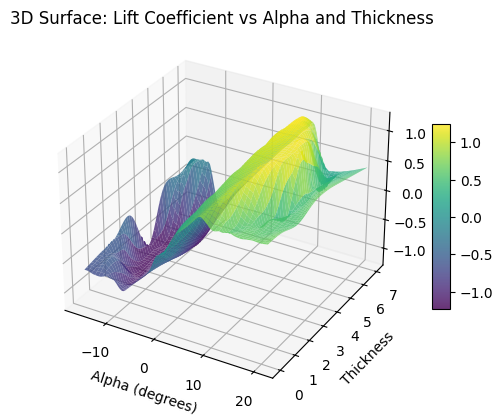

In [57]:
# Plot the lift for the airfoils in the bank

# Create a 2D figure and axis for the original 2D plot
fig, ax = plt.subplots()

# Create a 3D figure and axis for the 3D surface plot
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Define a colormap
cmap = plt.cm.viridis
norm = plt.Normalize(0, len(airfoil_names) - 1)

# Initialize lists to store data for the 3D surface plot
alpha_values = []
thickness_values = []
cl_values = []

# Get the list of all airfoil names in the bank
airfoil_names = kulfan_bank.list_airfoils()

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(airfoil_names):

    # Get kulfan parameters
    kulfan_params = kulfan_bank.get_airfoil(airfoil_name)

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )

    # Assume thickness is encoded in the airfoil name or can be extracted from Kulfan parameters
    thickness = kulfan_params.get("thickness", idx)  # Replace with actual thickness if available

    # Plot the 2D curve (alpha vs CL)
    ax.plot(alphas_nf, aero["CL"], label=airfoil_name, color=cmap(norm(idx)))

    # Store data for the 3D surface plot
    alpha_values.extend(alphas_nf)
    thickness_values.extend([thickness] * len(alphas_nf))
    cl_values.extend(aero["CL"])

# Add labels, title, and legend to the 2D plot
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CL")
ax.set_title("NeuralFoil Lift Plot for Different Thicknesses")
ax.legend()
ax.set_xlim(-16, 20)
ax.grid(True)

# Interpolate the data for the 3D surface plot
alpha_grid, thickness_grid = np.meshgrid(
    np.linspace(min(alpha_values), max(alpha_values), 100),
    np.linspace(min(thickness_values), max(thickness_values), 100)
)
cl_grid = griddata(
    (alpha_values, thickness_values), cl_values,
    (alpha_grid, thickness_grid), method='cubic'
)

# Plot the 3D surface
surf = ax_3d.plot_surface(
    alpha_grid, thickness_grid, cl_grid,
    cmap=cmap, edgecolor='none', alpha=0.8
)

# Add labels, title, and colorbar to the 3D plot
ax_3d.set_xlabel("Alpha (degrees)")
ax_3d.set_ylabel("Thickness")
ax_3d.set_zlabel("CL")
ax_3d.set_title("3D Surface: Lift Coefficient vs Alpha and Thickness")
fig_3d.colorbar(surf, ax=ax_3d, shrink=0.5, aspect=10)

# Show both plots
plt.show()

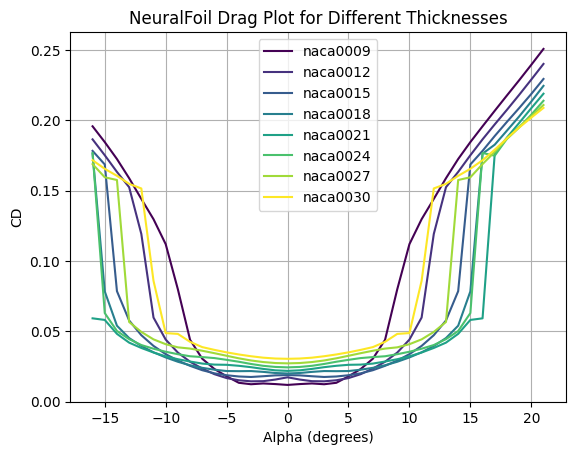

In [46]:
# Plot the drag for the airfoils in the bank

# Create a figure and an axis
fig, ax = plt.subplots()

# Get the list of all airfoil names in the bank
airfoil_names = kulfan_bank.list_airfoils()

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(airfoil_names):

    # Get kulfan parameters
    kulfan_params = kulfan_bank.get_airfoil(airfoil_name)

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )
    ax.plot(alphas_nf, aero["CD"], label=airfoil_name, color=cmap(norm(idx)))

# Add labels, title, and colorbar
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CD")
ax.set_title("NeuralFoil Drag Plot for Different Thicknesses")
ax.legend()
ax.grid(True)

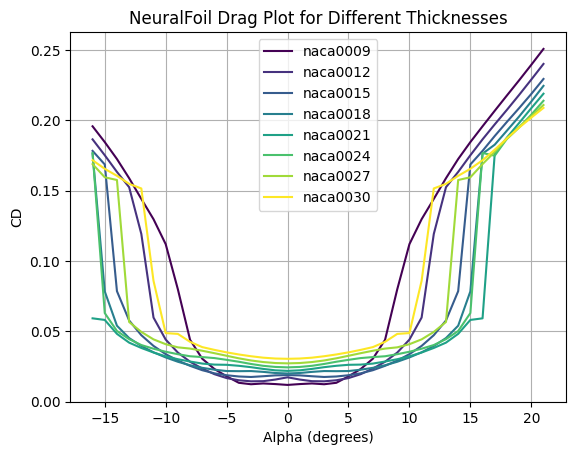

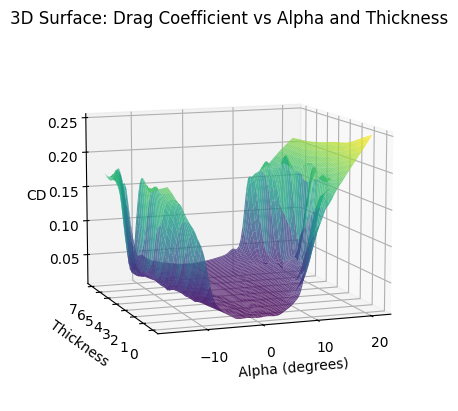

In [59]:
# Plot the drag for the airfoils in the bank

# Create a 2D figure and axis for the original 2D plot
fig, ax = plt.subplots()

# Create a 3D figure and axis for the 3D surface plot
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Define a colormap
cmap = plt.cm.viridis
norm = plt.Normalize(0, len(airfoil_names) - 1)

# Initialize lists to store data for the 3D surface plot
alpha_values = []
thickness_values = []
cd_values = []

# Get the list of all airfoil names in the bank
airfoil_names = kulfan_bank.list_airfoils()

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(airfoil_names):

    # Get kulfan parameters
    kulfan_params = kulfan_bank.get_airfoil(airfoil_name)

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )

    # Assume thickness is encoded in the airfoil name or can be extracted from Kulfan parameters
    thickness = kulfan_params.get("thickness", idx)  # Replace with actual thickness if available

    # Plot the 2D curve (alpha vs CD)
    ax.plot(alphas_nf, aero["CD"], label=airfoil_name, color=cmap(norm(idx)))

    # Store data for the 3D surface plot
    alpha_values.extend(alphas_nf)
    thickness_values.extend([thickness] * len(alphas_nf))
    cd_values.extend(aero["CD"])

# Add labels, title, and legend to the 2D plot
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CD")
ax.set_title("NeuralFoil Drag Plot for Different Thicknesses")
ax.legend()
ax.grid(True)

# Interpolate the data for the 3D surface plot
alpha_grid, thickness_grid = np.meshgrid(
    np.linspace(min(alpha_values), max(alpha_values), 100),
    np.linspace(min(thickness_values), max(thickness_values), 100)
)
cd_grid = griddata(
    (alpha_values, thickness_values), cd_values,
    (alpha_grid, thickness_grid), method='cubic'
)

# Plot the 3D surface
ax_3d.plot_surface(
    alpha_grid, thickness_grid, cd_grid,
    cmap=cmap, edgecolor='none', alpha=0.8
)

# Add labels and title to the 3D plot
ax_3d.set_xlabel("Alpha (degrees)")
ax_3d.set_ylabel("Thickness")
ax_3d.set_zlabel("CD")
ax_3d.set_title("3D Surface: Drag Coefficient vs Alpha and Thickness")
ax_3d.view_init(elev=10, azim=250)  # Adjust the view angle for better visualization

# Show both plots
plt.show()

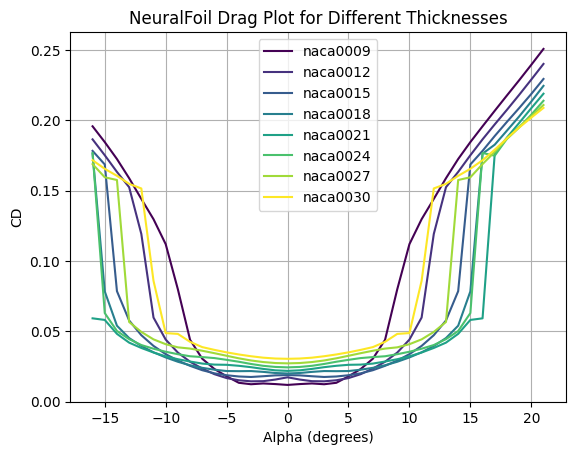

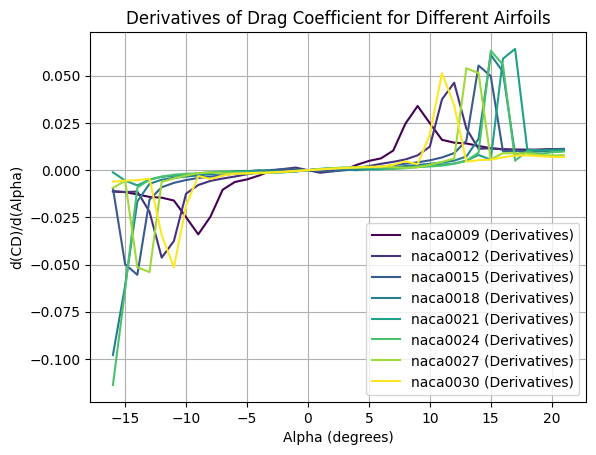

In [47]:
# Plot the drag for the airfoils in the bank

# Create a figure and an axis
fig, ax = plt.subplots()

# Get the list of all airfoil names in the bank
airfoil_names = kulfan_bank.list_airfoils()

# Dictionary to store derivatives for each airfoil
drag_derivatives = {}

# Function to compute numerical derivatives
def numerical_derivative(alpha, cd):
    return np.gradient(cd, alpha)

# Plot aero data for each model size using an index for the color
for idx, airfoil_name in enumerate(airfoil_names):

    # Get kulfan parameters
    kulfan_params = kulfan_bank.get_airfoil(airfoil_name)

    # Create aero dictionary
    aero = nf.get_aero_from_kulfan_parameters(
        kulfan_parameters=kulfan_params,
        alpha=alphas_nf,
        Re=Re,
        model_size="xxxlarge"
    )
    ax.plot(alphas_nf, aero["CD"], label=airfoil_name, color=cmap(norm(idx)))

    # Compute the numerical derivatives of the drag coefficient
    derivatives = numerical_derivative(alphas_nf, aero["CD"])
    drag_derivatives[airfoil_name] = derivatives

# Add labels, title, and colorbar to the drag plot
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("CD")
ax.set_title("NeuralFoil Drag Plot for Different Thicknesses")
ax.legend()
ax.grid(True)

# Create a new figure and axis for the derivatives plot
fig_derivatives, ax_derivatives = plt.subplots()

# Plot the derivatives for each airfoil
for idx, (airfoil_name, derivatives) in enumerate(drag_derivatives.items()):
    ax_derivatives.plot(
        alphas_nf, derivatives, label=f"{airfoil_name} (Derivatives)", color=cmap(norm(idx))
    )

# Add labels, title, and legend to the derivatives plot
ax_derivatives.set_xlabel("Alpha (degrees)")
ax_derivatives.set_ylabel("d(CD)/d(Alpha)")
ax_derivatives.set_title("Derivatives of Drag Coefficient for Different Airfoils")
ax_derivatives.legend()
ax_derivatives.grid(True)

# Show both plots
plt.show()